# Ph.D. Course - Data Vizualization 
#### Authors
-  Manuele Pasini - manuele.pasini@unibo.it
- Gianni Tumedei - gianni.tumedei2@unibo.it

In [1]:
import pandas as pd
import os
import numpy as np

input_path = os.path.join(os.sep, "home", "dataset")
preprocess_output_path = os.path.join(os.sep, "home", "preprocess_results")
output_path = os.path.join(os.sep, "home", "results")

#### Preprocessing

In [2]:
devices = pd.read_csv(os.path.join(input_path, "devices.csv"))
measurements = pd.read_csv(os.path.join(input_path, "measurements.csv"))

measurements["deveui"] = measurements["deveui"].str.replace("-", "").str.upper()
measurements = measurements.drop(
    columns=["acceleration_x", "acceleration_y", "acceleration_z"]
)
measurements = measurements.rename(columns={"deveui": "device_id"})

devices = devices.rename(
    columns={"id": "device_id", "location/0": "latitude", "location/1": "longitude"}
)
devices = devices.drop(columns=["type", "status", "installed", "addedBy"])


# Merge the two dataframes on the 'device_id' columncd
merged_df = pd.merge(devices, measurements, on="device_id")

# Convert the 'location' column to a (lon,lat) format
# merged_df["location"] = merged_df.apply(lambda row: f"{row['location/0']}, {row['location/1']}", axis=1)
# merged_df = merged_df.drop(columns=["location/0", "location/1"])

# Convert the 'timestamp' column to datetime format
merged_df["time"] = pd.to_datetime(merged_df["time"], unit="ms")
merged_df["time"] = merged_df["time"].dt.strftime("%Y-%m-%d %H:%M:%S")

# Remove columns with more than 60% missing values
missing_threshold = 0.6
cleaned_df = merged_df.loc[:, merged_df.isnull().mean() < missing_threshold]

merged_df.to_csv(os.path.join(preprocess_output_path, "merged_data.csv"), index=False)

### Dataset overview

In [ ]:
print(f"Number of devices: {merged_df["device_id"].unique().size}")
print(f"Number of distinct devices {merged_df["desc"].unique().size}")

print(f"Number of measurements: {merged_df.size}")
print(
    f"Measurements time window: from {merged_df["time"].min()} to {merged_df["time"].max()}"
)

merged_df

Number of devices: 429
Number of distinct devices 358
Number of measurements: 98437616
Measurements time window: from 2020-08-01 00:00:02 to 2021-02-23 20:32:28


,device_id,floor,desc,latitude,longitude,time,temperature,humidity,light,motion,co2,battery,sound_avg,sound_peak,moisture,pressure
0,A81758FFFE046433,4,Attached to old video projector mount,65.05765,25.46897,2020-08-01 00:01:10,23.6,39.0,2.0,20.0,NaN,3.641,34.0,64.0,NaN,NaN
1,A81758FFFE046433,4,Attached to old video projector mount,65.05765,25.46897,2020-08-01 00:05:11,23.7,39.0,2.0,21.0,NaN,3.638,34.0,64.0,NaN,NaN
2,A81758FFFE046433,4,Attached to old video projector mount,65.05765,25.46897,2020-08-01 00:09:10,23.6,39.0,2.0,21.0,NaN,3.638,34.0,64.0,NaN,NaN
3,A81758FFFE046433,4,Attached to old video projector mount,65.05765,25.46897,2020-08-01 00:13:11,23.7,39.0,2.0,22.0,NaN,3.641,34.0,64.0,NaN,NaN
4,A81758FFFE046433,4,Attached to old video projector mount,65.05765,25.46897,2020-08-01 00:17:11,23.6,39.0,2.0,18.0,NaN,3.641,34.0,64.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6152346,A81758FFFE030FFE,1,Hallway next to LO105,65.05809,25.46576,2021-02-23 19:29:38,21.8,7.0,41.0,2.0,635.0,3.689,NaN,NaN,NaN,NaN
6152347,A81758FFFE030FFE,1,Hallway next to LO105,65.05809,25.46576,2021-02-23 19:44:38,21.9,7.0,3.0,0.0,640.0,3.686,NaN,NaN,NaN,NaN
6152348,A81758FFFE030FFE,1,Hallway next to LO105,65.05809,25.46576,2021-02-23 19:59:38,21.8,7.0,3.0,0.0,636.0,3.689,NaN,NaN,NaN,NaN
6152349,A81758FFFE030FFE,1,Hallway next to LO105,65.05809,25.46576,2021-02-23 20:14:38,21.8,7.0,3.0,0.0,637.0,3.686,NaN,NaN,NaN,NaN


#### Filter, format, and group data for the first visualization

In [3]:
def clean_dataset(df, groupby_column, focus_column):
    filtered_df = df.copy()
    filtered_df["time"] = pd.to_datetime(
        filtered_df["time"], errors="coerce"
    ).dt.tz_localize("UTC", ambiguous="NaT")

    # Define the date ranges to exclude
    start_date = pd.Timestamp("2020-09-01T00:00:00Z")
    end_date = pd.Timestamp("2021-05-10T23:59:59Z")
    filtered_df = filtered_df[
        (filtered_df["time"] >= start_date) & (filtered_df["time"] <= end_date)
    ]

    exclusion_ranges = [
        (
            pd.Timestamp("2020-10-12T00:00:00Z"),
            pd.Timestamp("2020-10-18T23:59:59Z"),
        ),  # Autumn break (Syysloma) week 42
        (
            pd.Timestamp("2020-12-21T00:00:00Z"),
            pd.Timestamp("2021-01-06T23:59:59Z"),
        ),  # Christmas break
        (
            pd.Timestamp("2020-03-08T00:00:00Z"),
            pd.Timestamp("2020-03-14T23:59:59Z"),
        ),  # Winter break week 10
    ]
    # Apply filters
    for start, end in exclusion_ranges:
        filtered_df = filtered_df[
            ~((filtered_df["time"] >= start) & (filtered_df["time"] <= end))
        ]

    # Remove weekends
    filtered_df = filtered_df[filtered_df["time"].dt.weekday < 5]
    # Only keep floor 1
    filtered_df = filtered_df[filtered_df["floor"] == 1]
    # Only keep rows with motion and sound values
    filtered_df = filtered_df.dropna(subset=[groupby_column, focus_column])
    # Remove outliers
    outliers = ["A81758FFFE046462", "A81758FFFE04652A", "A81758FFFE046572"]
    filtered_df = filtered_df[~filtered_df["device_id"].isin(outliers)]

    if focus_column == "sound_avg":
        # Add linearized sound because plotting logarithmic values is useless
        filtered_df["sound_avg_linear"] = 10 ** (filtered_df["sound_avg"] / 20)
        filtered_df["sound_peak_linear"] = 10 ** (filtered_df["sound_peak"] / 20)

    filtered_df.to_csv(
        os.path.join(preprocess_output_path, "filtered_data.csv"), index=False
    )
    return filtered_df


filtered_df = clean_dataset(merged_df, "motion", "sound_avg")

In [ ]:
filtered_df["hour"] = filtered_df["time"].dt.hour

# Group by "device_id" and "hour"
grouped_df = (
    filtered_df.groupby(["device_id", "hour"])
    .agg(
        floor=("floor", "first"),
        desc=("desc", "first"),
        temperature=("temperature", "mean"),
        humidity=("humidity", "mean"),
        light=("light", "mean"),
        motion=("motion", "mean"),
        co2=("co2", "mean"),
        battery=("battery", "mean"),
        sound_avg=("sound_avg", "mean"),
        sound_peak=("sound_peak", "mean"),
        sound_avg_linear=("sound_avg_linear", "mean"),
        sound_peak_linear=("sound_peak_linear", "mean"),
        moisture=("moisture", "mean"),
        pressure=("pressure", "mean"),
        latitude=("latitude", "first"),
        longitude=("longitude", "first"),
    )
    .reset_index()
)

grouped_df.to_csv(os.path.join(preprocess_output_path, "grouped_data.csv"), index=False)

grouped_df

,device_id,hour,floor,desc,temperature,humidity,light,motion,co2,battery,sound_avg,sound_peak,sound_avg_linear,sound_peak_linear,moisture,pressure,latitude,longitude
0,A81758FFFE046337,0,1,In the middle of Kastari,21.276147,27.865443,0.000000,83.623853,NaN,3.635217,49.660550,64.000000,308.469821,1584.893192,NaN,NaN,65.05702,25.46767
1,A81758FFFE046337,1,1,In the middle of Kastari,21.269706,27.385294,0.000000,83.855882,NaN,3.635129,49.591176,64.002941,307.293440,1585.461975,NaN,NaN,65.05702,25.46767
2,A81758FFFE046337,2,1,In the middle of Kastari,21.056587,27.404192,0.362275,83.523952,NaN,3.635237,49.988024,66.287425,328.101785,3208.544770,NaN,NaN,65.05702,25.46767
3,A81758FFFE046337,3,1,In the middle of Kastari,20.535000,27.447059,1.629412,83.170588,NaN,3.635059,50.800000,70.438235,361.421157,5521.481641,NaN,NaN,65.05702,25.46767
4,A81758FFFE046337,4,1,In the middle of Kastari,20.091691,26.922636,2.644699,83.808023,NaN,3.634731,51.297994,72.074499,386.405504,6097.472105,NaN,NaN,65.05702,25.46767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2155,A81758FFFE046583,19,1,L7,20.184150,27.775216,26.841499,78.968300,NaN,3.627666,34.253602,64.510086,53.240307,2027.585352,NaN,NaN,65.05990,25.46602
2156,A81758FFFE046583,20,1,L7,20.156627,27.927711,25.262048,79.006024,NaN,3.627735,34.114458,64.096386,50.861932,1614.259575,NaN,NaN,65.05990,25.46602
2157,A81758FFFE046583,21,1,L7,20.121662,27.875371,26.243323,79.103858,NaN,3.627837,34.103858,64.080119,50.794251,1611.848977,NaN,NaN,65.05990,25.46602
2158,A81758FFFE046583,22,1,L7,20.076900,27.784195,25.680851,79.313070,NaN,3.627681,34.173252,64.036474,51.328041,1599.253923,NaN,NaN,65.05990,25.46602


### Visualization 1 - Manuele Pasini

In [5]:
groupby = "motion"
value = "co2"
filtered_df = clean_dataset(merged_df, groupby, value)

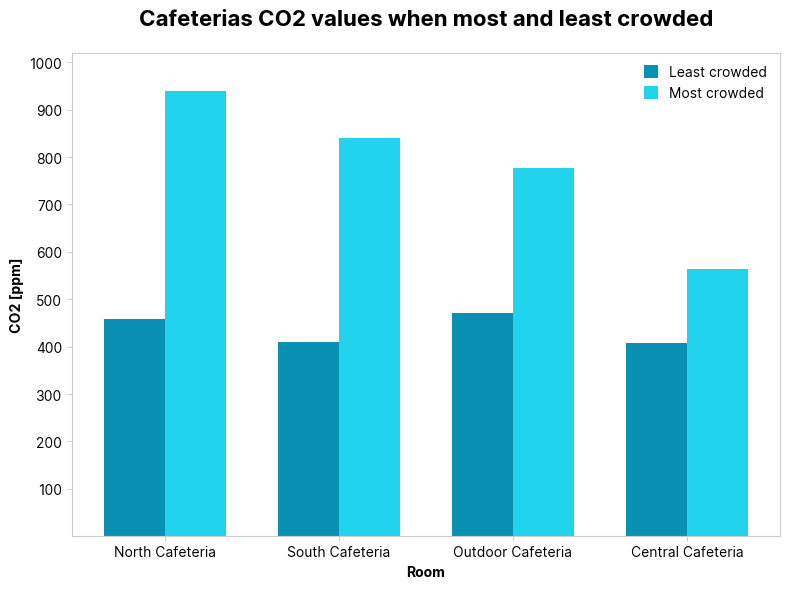

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

cafeteria_co2_devices = {
    "North Cafeteria": [
        "A81758FFFE030FB5",
        "A81758FFFE046576",
        "A81758FFFE031089",
    ],
    "Central Cafeteria": {"A81758FFFE030F7B", "A81758FFFE030F5A", "A81758FFFE031055"},
    "South Cafeteria": {
        "A81758FFFE031029",
        "A81758FFFE030F70",
    },
    "Outdoor Cafeteria": ["A81758FFFE031051", "A81758FFFE03102C", "A81758FFFE031005"],
}

device_to_cafeteria = {
    device: cafeteria
    for cafeteria, devices in cafeteria_co2_devices.items()
    for device in devices
}

co2_devices = list(device_to_cafeteria.keys())
filtered_df = filtered_df.loc[filtered_df["device_id"].isin(co2_devices)]
filtered_df["cafeteria"] = filtered_df["device_id"].map(device_to_cafeteria)

idx_min = filtered_df.groupby("device_id")[groupby].idxmin().dropna()
idx_max = filtered_df.groupby("device_id")[groupby].idxmax().dropna()

df_min = filtered_df.loc[idx_min].copy()
df_min["motion_type"] = "min"

df_max = filtered_df.loc[idx_max].copy()
df_max["motion_type"] = "max"

result = pd.concat([df_min, df_max])
result["cafeteria"] = result["device_id"].map(device_to_cafeteria)

pivot = result.pivot(index="device_id", columns="motion_type", values="co2")
pivot = pivot.loc[pivot["min"] < pivot["max"]]
pivot["cafeteria"] = pivot.index.map(device_to_cafeteria)

pivot_grouped = pivot.groupby("cafeteria")[["min", "max"]].mean()
pivot_grouped = pivot_grouped.sort_values(by="max", ascending=False)


def plot_grouped(pivot_grouped, cap_value=1300, log=False):
    plt.rcParams["font.family"] = "Inter"

    x = np.arange(len(pivot_grouped))
    width = 0.35

    co2_min = pivot_grouped["min"].clip(upper=cap_value)
    co2_max = pivot_grouped["max"].clip(upper=cap_value)

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.bar(x - width / 2, co2_min, width, label="Least crowded", color="#0891b2")
    ax.bar(x + width / 2, co2_max, width, label="Most crowded", color="#22d3ee")

    for i, val in enumerate(pivot_grouped["min"]):
        if val > cap_value:
            ax.text(
                x[i] - width / 2,
                cap_value,
                f"{val:.0f}",
                ha="center",
                va="bottom",
                fontsize=9,
            )
    for i, val in enumerate(pivot_grouped["max"]):
        if val > cap_value:
            ax.text(
                x[i] + width / 2,
                cap_value,
                f"{val:.0f}",
                ha="center",
                va="bottom",
                fontsize=9,
            )

    ax.set_xlabel("Room", fontweight="bold")
    ax.set_ylabel("CO2 [ppm]", fontweight="bold")

    title = f"Cafeterias CO2 values when most and least crowded"
    if log:
        ax.set_yscale("log")
    ax.set_title(title, fontweight="bold", fontsize=16, pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(pivot_grouped.index, rotation=0)
    ax.set_yticks(np.arange(0, cap_value + 100, 100))
    ax.legend(
        frameon=False,
        handlelength=1,
        handleheight=1,
    )
    ax.set_ylim(1, cap_value + 20 if not log else cap_value * 2)

    ax.tick_params(color="#cccccc")
    for spine in ax.spines.values():
        spine.set_edgecolor("#cccccc")

    # plt.subplots_adjust(left=0.3, top=0.88, bottom=0.5)
    plt.tight_layout()

    plt.savefig(os.path.join(output_path, f"co2_plot_{log}.png"), dpi=300)
    plt.show()


# 8. Esegui i plot
plot_grouped(pivot_grouped, cap_value=1000, log=False)
# plot_grouped(pivot_grouped, cap_value=1100, log=True)
# pivot_grouped

### Visualization 1 - Gianni Tumedei